In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_with_father'
batch='WILD_with_father'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_WILD_with_father2500.npy', 
                                   allow_pickle=True).item()

In [4]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

In [5]:
# remove unclean data
dict_results_across_mice.pop('W8Fam')

,area,n_cells,energy,acronym
0,Frontal pole cerebral cortex,0,0.000000,FRP
1,Primary motor area,13,30259.839681,MOp
2,Secondary motor area,73,90728.748170,MOs
3,Primary somatosensory area,68,74750.821654,SSp
4,Supplemental somatosensory area,33,90321.580594,SSs
...,...,...,...,...
194,Interfascicular nucleus raphe,1,50477.370504,IF
195,Interpeduncular nucleus,0,0.000000,IPN
196,Rostral linear nucleus raphe,0,0.000000,RL
197,Central linear nucleus raphe,1,70776.185821,CLI


# Format data for task PLS

In [6]:
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='n_cells')
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='energy')

In [7]:
data_ncells = pd.read_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy = pd.read_csv('./results_pls/'+batch+'_energy.csv')

# Format data for hierarchy plotting

In [8]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS for all areas and energy

In [9]:
%%bash
python area_pls.py -i results_pls/WILD_with_father_n_cells.csv -o './results_pls/WILD_with_father'

2023-09-11 15:23:51 PC1QFRRQ __main__[390824] INFO reading data...
2023-09-11 15:23:51 PC1QFRRQ __main__[390824] INFO computing PLS...
2023-09-11 15:23:51 PC1QFRRQ __main__[390824] INFO PLS computed, now performing bootstrap...
2023-09-11 15:23:51 PC1QFRRQ __main__[390824] INFO saving output data...


In [10]:
# %%bash
# python area_pls.py -i results_pls/WILD_with_father_energy.csv -o './results_pls/WILD_with_father_energy'

# Plot results

In [11]:
contrasts = pd.read_csv('./results_pls/WILD_with_father_contrasts.csv')
saliences = pd.read_csv('./results_pls/WILD_with_father_saliences.csv')
contrasts = contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

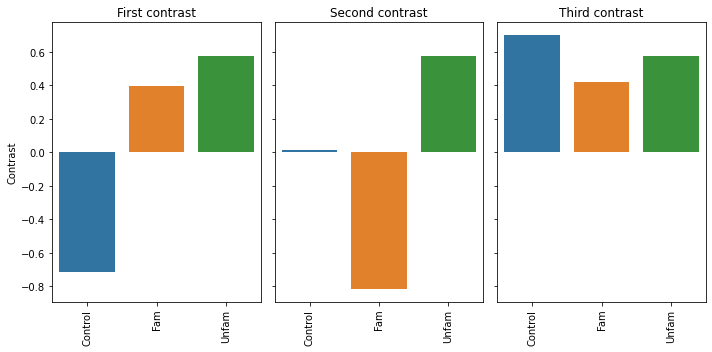

In [12]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.plot_contrasts(df_data=contrasts, index=0, ax=axes[0])
upls.plot_contrasts(df_data=contrasts, index=1, ax=axes[1])
upls.plot_contrasts(df_data=contrasts, index=2, ax=axes[2])
axes[0].set_ylabel('Contrast')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
plt.tight_layout()
plt.savefig('./results_pls/WILD_with_father_pls_contrasts_all_areas.png')
plt.savefig('./results_pls/WILD_with_father_pls_contrasts_all_areas.svg')

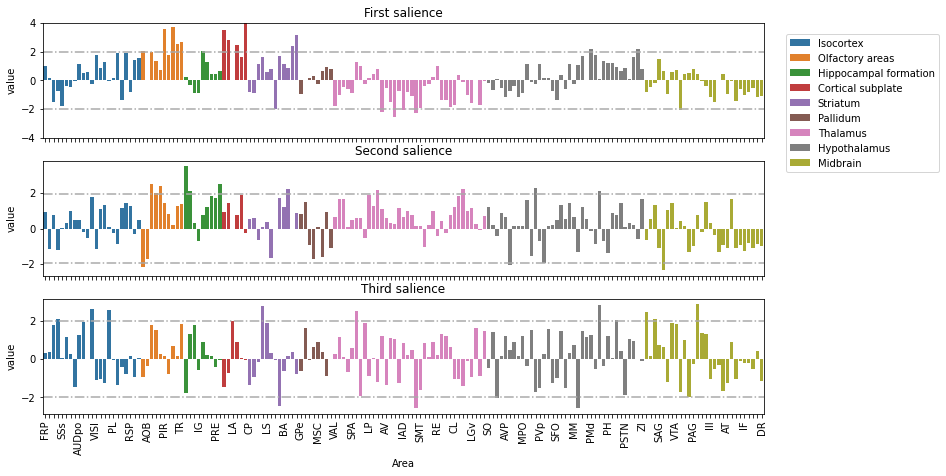

In [13]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,7))
plt.subplots_adjust(top=0.9, left=0.03, right=0.8)
upls.plot_saliences(df_data=saliences, index=0, ax=axes[0], df_levels=df_levels)
upls.plot_saliences(df_data=saliences, index=1, ax=axes[1], df_levels=df_levels)
upls.plot_saliences(df_data=saliences, index=2, ax=axes[2], df_levels=df_levels)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[0].set_ylim(-4,4)
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
axes[0].legend(loc='right', bbox_to_anchor=(1.25,0.3))
axes[1].get_legend().remove()
axes[2].get_legend().remove()
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
plt.savefig('./results_pls/WILD_with_father_pls_saliences_all_areas.png')
plt.savefig('./results_pls/WILD_with_father_pls_saliences_all_areas.svg')

# Identify areas with significant salience contribution

In [14]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=saliences, 
                                       threshold=1.96, 
                                       volumes=volumes)
np.save('results_pls/pls_sig_areas_WILD_with_father.npy', pls_sig_areas)

In [15]:
pls_sig_areas = np.load('results_pls/pls_sig_areas_WILD_with_father.npy', allow_pickle=True)
pls_sig_areas

array(["Ammon's horn", 'Anterior amygdalar area',
       'Anterior cingulate area', 'Anterior olfactory nucleus',
       'Anterodorsal nucleus', 'Anteromedial visual area',
       'Anteroventral periventricular nucleus',
       'Arcuate hypothalamic nucleus', 'Basolateral amygdalar nucleus',
       'Central amygdalar nucleus', 'Claustrum',
       'Cortical amygdalar area', 'Dentate gyrus',
       'Dorsal peduncular area', 'Dorsal premammillary nucleus',
       'Endopiriform nucleus', 'Entorhinal area',
       'Interanterodorsal nucleus of the thalamus',
       'Intercalated amygdalar nucleus', 'Lateral amygdalar nucleus',
       'Lateral preoptic area', 'Main olfactory bulb',
       'Medial amygdalar nucleus', 'Mediodorsal nucleus of thalamus',
       'Midbrain reticular nucleus retrorubral area',
       'Nucleus of the brachium of the inferior colliculus',
       'Olfactory tubercle', 'Parabigeminal nucleus',
       'Parastrial nucleus',
       'Paraventricular hypothalamic nucleus de